# producing input data for fitness estimator

## Imports

In [1]:
import multiprocess as mp
import os, shutil, numpy
from matplotlib import pyplot
import math

In [2]:
from GillespieSimulator.GillespieEngine import GillespieEngine
from GillespieSimulator.Parameters import Parameters

In [3]:
from GillespieSimulator.analysis import *

## Setup the parameters 
We initialize the competition matrix as $C_{ij}\equiv 0$ and later inject the equilibrated matrix elements. We resort to this hack because the competition matrix is no accessible through the public API of the `GillespieEngine`.

In [4]:
parameters = Parameters(max_time=10,
         max_population_size=None,
         division_rate=1.0,
         division_rate_fwhm=0.0,
         mutation_probability=0.0,
         death_rate=0.0,
         death_rate_fwhm=0.0,
         pdf_mean=0.00,
         pdf_rms=.000,
         barcode_size=0,
         genome_size=1,
         carrying_capacity=10000,
         theta=0,
        )
         

### Simulation output

In [10]:
output_dir = 'fitness'

In [11]:
pwd

'/home/grotec/repos/gillespiesimulator/doc/source/include/notebooks'

### Define a function that performs a simulation run. 
Inject the competition matrix. Each lineage is **dominant** against one other lineage and **dominated** by another one. We scale the coefficients by a factor $\propto \left|C\right|_{\mathrm{max}}^{2}$ so that competition only becomes important near carrying capacity. $\left|.\right|_{\mathrm{max}}$ is the maximum norm.

In [153]:
def run_engine(run_number):
    # print("Setting seed")
    seed = run_number
    numpy.random.seed(seed)
    
    # print("Setting up engine.")
    engine = GillespieEngine(parameters=parameters,
                             population=[10, 10, 10],
                             outdir=os.path.join(output_dir,'gillespie_run_out_{0:04d}'.format(run_number))
                            )
    # Inject the competition matrix.
    
    engine._GillespieEngine__competition_matrix = 10.0**numpy.array([
                                                               [-9, -2, -2],
                                                               [-9, -9, -2],
                                                               [-9, -9, -9],
                                                              ]
                                                             )
    # print("Running the engine")
    engine.run(snapshot_interval=0.1)
    
    print("Simulation data was written to {}.".format(engine.outdir))

In [154]:
if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

# Run one simulation (e.g. for testing purposes)
run_engine(number_of_runs)

Simulation data was written to fitness/gillespie_run_out_0128.


In [18]:
runs = load_runs([os.path.join(output_dir,d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d))])

In [20]:
display(interactive_plot_widget(runs))

## Setup the process pool

### Determine number of processes available to this run.

In [157]:
number_of_cpus = mp.cpu_count()
print("There are {} CPUs on this system.".format(number_of_cpus))

There are 48 CPUs on this system.


### Set number of runs 

In [158]:
number_of_runs = 128
runs = range(number_of_runs)

### Set the number of cpus to use in this run.
This number should be equal or less to the number of simulations to run to avoid idling processes. It's ok to oversubscribe the CPU that is to make a pool that has more processes than there are CPU cores.

In [159]:
pool_size = min(number_of_runs, number_of_cpus); pool_size

48

In [160]:
# Run the pool of simulations in parallel.
with mp.Pool(pool_size) as pool:

### We use the `imap_unordered` method of `Pool` to take advantage of the `chunksize` parameter, which in the case of many long runs reduces the memory consumption. 
    pool.imap_unordered(run_engine, runs, chunksize=1)
    pool.close()
    pool.join()

Simulation data was written to fitness/gillespie_run_out_0013.
Simulation data was written to fitness/gillespie_run_out_0028.
Simulation data was written to fitness/gillespie_run_out_0015.
Simulation data was written to fitness/gillespie_run_out_0047.Simulation data was written to fitness/gillespie_run_out_0034.

Simulation data was written to fitness/gillespie_run_out_0033.
Simulation data was written to fitness/gillespie_run_out_0039.
Simulation data was written to fitness/gillespie_run_out_0018.Simulation data was written to fitness/gillespie_run_out_0006.

Simulation data was written to fitness/gillespie_run_out_0026.Simulation data was written to fitness/gillespie_run_out_0031.
Simulation data was written to fitness/gillespie_run_out_0046.

Simulation data was written to fitness/gillespie_run_out_0010.Simulation data was written to fitness/gillespie_run_out_0035.
Simulation data was written to fitness/gillespie_run_out_0029.

Simulation data was written to fitness/gillespie_run_ou

## Visualize results

In [161]:
runs = load_runs([os.path.join(output_dir,d) for d in os.listdir(output_dir)])

In [162]:
display(interactive_plot_widget(runs))

### Filter out those runs with 3 surviving lineages 

In [ ]:
# Per run, make a csv file: columns map to time points, rows map to lineage frequencies


In [164]:
# Make dictionary {run: mutant} from output data.
all_mutants = dict([(run, mutants(runs[run])) for run in runs.keys()])

In [180]:
for k,v in all_mutants.items():
    #v.columns = v.columns.droplevel('Mutant ID')
    v.index = range(len(v.index))
    v.T.to_csv(os.path.join(output_dir,'run_{}.csv'.format(k)), index=False)

In [189]:
v.T

0   1   2   3   4   5   6   7   8   9   ...    89    90    91    92    93  \
0  10  10  10  10  11  12  13  14  14  15  ...     0     0     0     0     0   
1  10  11  11  12  15  16  17  18  21  21  ...     0     0     0     0     0   
2  10  12  13  16  18  22  24  27  30  36  ...  9328  9388  9452  9505  9551   

     94    95    96    97    98  
0     0     0     0     0     0  
1     0     0     0     0     0  
2  9587  9617  9653  9683  9685  

[3 rows x 99 columns]

In [190]:
!pwd

/home/grotec/repos/gillespiesimulator/doc/source/include/notebooks


In [ ]:
!python pyfitseq.py -i run_1_csv

In [203]:
estimates = pandas.read_csv(os.path.join(output_dir,'out_run_0_FitSeq.csv'))

In [204]:
estimates

Estimated_Fitness  Likelihood_Log  Estimated_Mean_Fitness  \
0           -0.068122      -92.452929                0.000000   
1           -0.057588     -146.287189                0.008150   
2            0.125710     -487.744462               -0.001289   
3                 NaN             NaN                0.000103   
4                 NaN             NaN               -0.000572   
..                ...             ...                     ...   
93                NaN             NaN                0.125710   
94                NaN             NaN                0.125710   
95                NaN             NaN                0.125710   
96                NaN             NaN                0.125710   
97                NaN             NaN                0.125710   

    Estimated_Read_Number_t0  Estimated_Read_Number_t1  \
0                       10.0                      10.0   
1                       10.0                      10.0   
2                       10.0                      12.0   
3                        NaN                       NaN   
4                        NaN                       NaN   
..                       ...                       ...   
93                       NaN                       NaN   
94                       NaN                       NaN   
95                       NaN                       NaN   
96                       NaN                       NaN   
97                       NaN                       NaN   

    Estimated_Read_Number_t2  Estimated_Read_Number_t3  \
0                       13.0                      14.0   
1                       14.0                      15.0   
2                       13.0                      15.0   
3                        NaN                       NaN   
4                        NaN                       NaN   
..                       ...                       ...   
93                       NaN                       NaN   
94                       NaN                       NaN   
95                       NaN                       NaN   
96                       NaN                       NaN   
97                       NaN                       NaN   

    Estimated_Read_Number_t4  Estimated_Read_Number_t5  \
0                       14.0                      18.0   
1                       16.0                      24.0   
2                       15.0                      19.0   
3                        NaN                       NaN   
4                        NaN                       NaN   
..                       ...                       ...   
93                       NaN                       NaN   
94                       NaN                       NaN   
95                       NaN                       NaN   
96                       NaN                       NaN   
97                       NaN                       NaN   

    Estimated_Read_Number_t6  ...  Estimated_Read_Number_t88  \
0                       20.0  ...                        0.0   
1                       25.0  ...                        0.0   
2                       25.0  ...                     8853.0   
3                        NaN  ...                        NaN   
4                        NaN  ...                        NaN   
..                       ...  ...                        ...   
93                       NaN  ...                        NaN   
94                       NaN  ...                        NaN   
95                       NaN  ...                        NaN   
96                       NaN  ...                        NaN   
97                       NaN  ...                        NaN   

    Estimated_Read_Number_t89  Estimated_Read_Number_t90  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                      8954.0                     9048.0   
3                         NaN                        NaN   
4                         NaN                        NaN   
.. 

In [205]:
estimated_cell_counts = estimates.T.loc["Estimated_Read_Number_t0":,:2]

In [206]:
estimated_cell_counts.index = [idx.split('t')[-1] for idx in estimated_cell_counts.index]

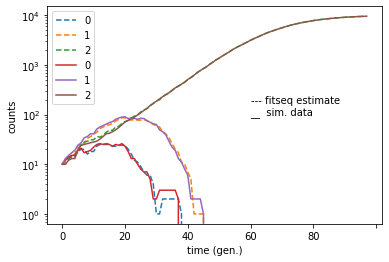

In [212]:
fig, ax = pyplot.subplots()
estimated_cell_counts.plot(logy=True, ax=ax, style='--')
all_mutants[0].plot(logy=True, ax=ax)
_ = ax.set_xlabel("time (gen.)")
_ = ax.set_ylabel("counts")
_ = ax.text(60, 100, "--- fitseq estimate\n__  sim. data")